# Model: Random Forest with all the columns and hyperparmeters optimisation

In this notebook, all the training/predictions steps are implemented for a very basic model (random forest with all the features). 
The goal is to get the best f1-score ! May the force be with you 🧨🧨  

# Import libraries

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score,precision_score, RocCurveDisplay
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

import optuna
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from IPython.display import display

/home/nick/.virtualenvs/conversion-rate-challenge/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read file with labels

In [ ]:
data = pd.read_csv('../data/processed/conversion_data_train_EDA_without_outliers_fe_output.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [3]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


# Make your model

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

In [4]:
target_variable = 'converted'
X = data.drop(columns=[target_variable])
Y = data.loc[:, target_variable]
print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited'], dtype='object')



In [5]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=925662591, stratify=Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



## Training pipeline

In [6]:
# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")

# Create pipeline for numeric features
display(X.select_dtypes(exclude='object') )
numeric_features = X.select_dtypes(exclude='object').columns  # Names of numeric columns in X_train/X_test
numeric_transformer = Pipeline(
    steps=[
        (
            "scaler", 
            StandardScaler()
        ),
    ]
)

display(X.select_dtypes(include='object') )

# Create pipeline for categorical features
categorical_features = X.select_dtypes(include='object').columns  # Names of categorical columns in X_train/X_test
categorical_transformer = Pipeline(
    steps=[
        (
            "encoder",
            OneHotEncoder(drop="first"),
        ),  # first column will be dropped to avoid creating correlations between features
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
preprocessor.fit(X_train)
X_train = preprocessor.transform(X_train)
print("...Done.")
print(
    X_train[0:5]
)  # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()

Encoding categorical features and standardizing numerical features...


,age,new_user,total_pages_visited
0,22,1,2
1,21,1,3
2,20,0,14
3,23,1,3
4,28,1,3
...,...,...,...
284575,36,1,1
284576,31,1,2
284577,41,1,5
284578,31,1,4


,country,source
0,China,Direct
1,UK,Ads
2,Germany,Seo
3,US,Seo
4,US,Direct
...,...,...
284575,US,Ads
284576,US,Seo
284577,US,Seo
284578,US,Direct


Performing preprocessings on train set...
       country  age  new_user  source  total_pages_visited
78494    China   29         0     Seo                    3
85888       US   39         1     Ads                    6
22034       US   27         0  Direct                    6
150320      US   30         1  Direct                    3
258267      US   39         0     Seo                    3
...Done.
[[-0.18828281 -1.47841668 -0.56102362  0.          0.          0.
   0.          1.        ]
 [ 1.02180941  0.67639929  0.33673615  0.          0.          1.
   0.          0.        ]
 [-0.43030125 -1.47841668  0.33673615  0.          0.          1.
   1.          0.        ]
 [-0.06727359  0.67639929 -0.56102362  0.          0.          1.
   1.          0.        ]
 [ 1.02180941 -1.47841668 -0.56102362  0.          0.          1.
   0.          1.        ]]



In [7]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
import numpy as np
import pandas as pd

# --- XGBoostClassifier with Optuna (Optimizing for F1-Score) ---
print("Optimizing XGBoostClassifier with Optuna...")

def objective_xgb(trial):
    # Define the hyperparameter search space for XGBoost
    param = {
        'objective': 'binary:logistic',  # For binary classification
        'eval_metric': 'logloss',        # Evaluation metric for early stopping
        'seed': 42,
        'n_jobs': -1,
        'tree_method': 'hist',           # Use 'hist' for faster training on large datasets

        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
    }

    model = XGBClassifier(**param)

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_f1_scores = []

    # Access underlying NumPy arrays for indexing
    X_train_np = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
    Y_train_np = Y_train.values if isinstance(Y_train, pd.Series) else Y_train

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train_np, Y_train_np)):
        X_train_fold, X_val_fold = X_train_np[train_idx], X_train_np[val_idx]
        Y_train_fold, Y_val_fold = Y_train_np[train_idx], Y_train_np[val_idx]

        model.fit(X_train_fold, Y_train_fold,
                  eval_set=[(X_val_fold, Y_val_fold)],
                  verbose=False)

        Y_val_pred = model.predict(X_val_fold)
        current_f1 = f1_score(Y_val_fold, Y_val_pred)

        fold_f1_scores.append(current_f1)
        trial.report(np.mean(fold_f1_scores), fold_idx)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return np.mean(fold_f1_scores)

# Create a study object with a pruner
study_xgb = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(
    n_startup_trials=5,
    n_warmup_steps=0,
    interval_steps=1
))

study_xgb.optimize(objective_xgb, n_trials=100)

print("\n--- XGBoost Optimization Results ---")
print("Best hyperparameters (XGBoost): ", study_xgb.best_params)
print("Best validation F1-score (XGBoost): ", study_xgb.best_value)

# --- Train the best XGBoost model ---
best_xgb_model = XGBClassifier(**study_xgb.best_params, objective='binary:logistic', eval_metric='logloss', seed=42, n_jobs=-1)
best_xgb_model.fit(X_train, Y_train)

[I 2025-06-11 19:58:23,776] A new study created in memory with name: no-name-eae59b9c-4f23-4a00-83ab-4422b199f9b2


Optimizing XGBoostClassifier with Optuna...


[I 2025-06-11 19:59:48,378] Trial 0 finished with value: 0.7504172235441912 and parameters: {'lambda': 2.8670887731274377e-05, 'alpha': 0.0024480146562839327, 'colsample_bytree': 0.7900229621270616, 'subsample': 0.5399644508180901, 'learning_rate': 0.03911368226092672, 'n_estimators': 1918, 'max_depth': 8, 'min_child_weight': 6, 'gamma': 0.00024977202295395644}. Best is trial 0 with value: 0.7504172235441912.
[I 2025-06-11 19:59:50,493] Trial 1 finished with value: 0.0 and parameters: {'lambda': 1.1802349305911602e-07, 'alpha': 1.2544785364674536e-05, 'colsample_bytree': 0.5511655228492969, 'subsample': 0.6414692000092865, 'learning_rate': 0.002168968103307951, 'n_estimators': 140, 'max_depth': 3, 'min_child_weight': 9, 'gamma': 0.00026159688083741354}. Best is trial 0 with value: 0.7504172235441912.
[I 2025-06-11 20:00:00,981] Trial 2 finished with value: 0.6998381334203433 and parameters: {'lambda': 4.5162882637535355e-07, 'alpha': 6.423717562479075e-07, 'colsample_bytree': 0.2163525


--- XGBoost Optimization Results ---
Best hyperparameters (XGBoost):  {'lambda': 1.3894254352064468e-08, 'alpha': 1.3798513506501405e-07, 'colsample_bytree': 0.8858465732935421, 'subsample': 0.3233323784528214, 'learning_rate': 0.006103872701989545, 'n_estimators': 1986, 'max_depth': 3, 'min_child_weight': 8, 'gamma': 1.049498710042585e-05}
Best validation F1-score (XGBoost):  0.7610793562972067


XGBClassifier(alpha=1.3798513506501405e-07, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8858465732935421, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=1.049498710042585e-05, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              lambda=1.3894254352064468e-08, learning_rate=0.006103872701989545,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=8, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1986, ...)

In [8]:
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
)

print("Generating Optuna Visualization Plots...")

# 1. Plot Optimization History
# Shows how the objective value (F1-score in your case) changed over trials.
# You can see if the optimization is converging or if there's still potential for improvement.
fig_history = plot_optimization_history(study_xgb)
fig_history.show()


# 2. Plot Parameter Importances
# Shows which hyperparameters were most influential in determining the objective value.
# This helps you understand which parameters had the biggest impact on your F1-score.
fig_importances = plot_param_importances(study_xgb)
fig_importances.show()

Generating Optuna Visualization Plots...


In [9]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = best_xgb_model.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



## Test pipeline

In [10]:
# Use X_test, and the same preprocessings as in training pipeline, 
# but call "transform()" instead of "fit_transform" methods (see example below)

print("Encoding categorical features and standardizing numerical features...")

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head())
X_test = preprocessor.transform(
    X_test
)  # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print("...Done.")
print(
    X_test[0:5, :]
)  # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore
print()

Encoding categorical features and standardizing numerical features...
Performing preprocessings on test set...
       country  age  new_user source  total_pages_visited
147254      US   17         1    Ads                    6
117873   China   29         1    Seo                    5
22117    China   43         0    Seo                    4
113781   China   31         1    Ads                    6
87386       US   37         1    Seo                    6
...Done.
[[-1.64039347  0.67639929  0.33673615  0.          0.          1.
   0.          0.        ]
 [-0.18828281  0.67639929  0.0374829   0.          0.          0.
   0.          1.        ]
 [ 1.50584629 -1.47841668 -0.26177036  0.          0.          0.
   0.          1.        ]
 [ 0.05373563  0.67639929  0.33673615  0.          0.          0.
   0.          0.        ]
 [ 0.77979096  0.67639929  0.33673615  0.          0.          1.
   0.          1.        ]]



In [11]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = best_xgb_model.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



## Performance assessment

In [12]:
# --- 4. Analyze Feature Importance ---

column_names = [col.split('__')[1] for col in preprocessor.get_feature_names_out()]

# --- Utility function to map fN names to original names ---
def get_mapped_importance(booster, importance_type, feature_names):
    # Get scores as a dictionary, keys will be 'f0', 'f1', etc., if not explicitly named in booster
    score_dict = booster.get_score(importance_type=importance_type)

    # Create a Series with fN names as index
    # Ensure all original feature indices are present, even if their score is 0
    full_scores = pd.Series(0.0, index=[f'f{i}' for i in range(len(feature_names))])
    full_scores.update(pd.Series(score_dict)) # Update with actual scores

    # Map fN names back to original feature names
    mapped_scores = full_scores.rename(index=lambda x: feature_names[int(x[1:])])
    return mapped_scores.sort_values(ascending=False)

# Get feature importance (gain is default for .feature_importances_)
importance_gain = pd.Series(best_xgb_model.feature_importances_, index=column_names).sort_values(ascending=False)

# Convert to DataFrame for Plotly
importance_df = importance_gain.reset_index()
importance_df.columns = ['Feature', 'Importance (Gain)']

# --- 5. Plot Feature Importance using Plotly Express ---
fig = px.bar(importance_df,
             x='Importance (Gain)',
             y='Feature',
             orientation='h', # Horizontal bars
             title='XGBoost Feature Importance (Gain)',
             labels={'Importance (Gain)': 'Importance (Gain)', 'Feature': 'Feature Name'},
             height=500) # Adjust height as needed

fig.update_layout(
    xaxis_title_text='Importance (Gain)',
    yaxis_title_text='Feature Name',
    yaxis_categoryorder='total ascending' # Order bars by value
)

fig.show()

# --- Optional: Plot other importance types using Plotly Graph Objects ---
# --- Get and Plot Feature Importance (Weight) ---

booster = best_xgb_model.get_booster()

importance_weight = get_mapped_importance(booster, 'weight', column_names)
importance_df_weight = importance_weight.reset_index()
importance_df_weight.columns = ['Feature', 'Importance (Weight)']

fig_weight = px.bar(importance_df_weight,
                    x='Importance (Weight)',
                    y='Feature',
                    orientation='h',
                    title='XGBoost Feature Importance (Weight - Number of Times Used)',
                    labels={'Importance (Weight)': 'Importance (Weight)', 'Feature': 'Feature Name'},
                    height=500)
fig_weight.update_layout(xaxis_title_text='Importance (Weight)', yaxis_title_text='Feature Name', yaxis_categoryorder='total ascending')
fig_weight.show()

# --- Get and Plot Feature Importance (Cover) ---
importance_cover = get_mapped_importance(booster, 'cover', column_names)
importance_df_cover = importance_cover.reset_index()
importance_df_cover.columns = ['Feature', 'Importance (Cover)']

fig_cover = px.bar(importance_df_cover,
                   x='Importance (Cover)',
                   y='Feature',
                   orientation='h',
                   title='XGBoost Feature Importance (Cover - Average Coverage)',
                   labels={'Importance (Cover)': 'Importance (Cover)', 'Feature': 'Feature Name'},
                   height=500)
fig_cover.update_layout(xaxis_title_text='Importance (Cover)', yaxis_title_text='Feature Name', yaxis_categoryorder='total ascending')
fig_cover.show()

In [13]:
print("f1-score:")
print()
print("* f1-score on training set: ", f1_score(Y_train, Y_train_pred))
print("* f1-score on test set: ", f1_score(Y_test,Y_test_pred))
print()

print("accuracy:")
print()
print("* accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("* accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("recall:")
print()
print("* recall-score on training set: ", recall_score(Y_train, Y_train_pred))
print("* recall-score on training set: ", recall_score(Y_test, Y_test_pred))
print()

print("precision:")
print()
print("* precision-score on training set: ", precision_score(Y_train, Y_train_pred))
print("* precision-score on test set: ", precision_score(Y_test, Y_test_pred))

f1-score:

* f1-score on training set:  0.7641509433962265
* f1-score on test set:  0.7784040344111539

accuracy:

* accuracy on training set :  0.9861638203668565
* accuracy on test set :  0.986875395319418

recall:

* recall-score on training set:  0.6948529411764706
* recall-score on training set:  0.7145969498910676

precision:

* precision-score on training set:  0.8488023952095808
* precision-score on test set:  0.8547231270358306


In [14]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[219411    909]
 [  2241   5103]]

Confusion matrix on test set : 
[[54857   223]
 [  524  1312]]



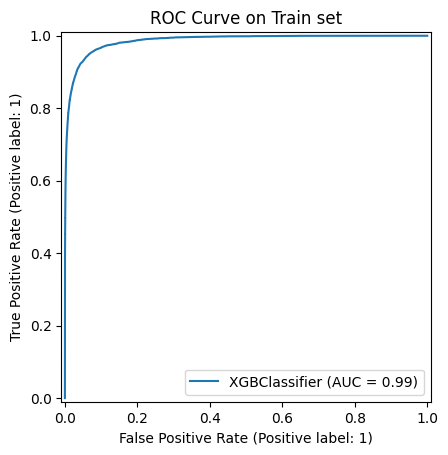

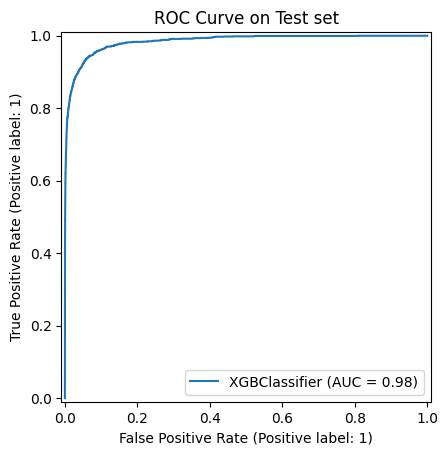

In [15]:
_, ax = plt.subplots()
ax.set(
    title="ROC Curve on Train set"
)  # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(
    best_xgb_model, X_train, Y_train, ax=ax
)  # RocCurveDisplay from sklearn
plt.show()

_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="ROC Curve on Test set"
)  # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(
    best_xgb_model, X_test, Y_test, ax=ax
)  # RocCurveDisplay from sklearn
plt.show()

**Our baseline model reaches a f1-score of almost 70%. Now, feel free to refine your model and try to beat this score ! 🚀🚀**

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [16]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

best_xgb_model.fit(X,Y)

XGBClassifier(alpha=1.3798513506501405e-07, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8858465732935421, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=1.049498710042585e-05, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              lambda=1.3894254352064468e-08, learning_rate=0.006103872701989545,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=8, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1986, ...)

In [17]:
# Read data without labels
data_without_labels = pd.read_csv('../data/raw/conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

print(data_without_labels.head())

Prediction set (without labels) : (31620, 5)
  country  age  new_user  source  total_pages_visited
0      UK   28         0     Seo                   16
1      UK   22         1  Direct                    5
2   China   32         1     Seo                    1
3      US   32         1     Ads                    6
4   China   25         0     Seo                    3


In [ ]:
data_without_labels['total_pages_visited_x2'] = data_without_labels['total_pages_visited'] ** 2
data_without_labels['total_pages_visited_age'] = data_without_labels['total_pages_visited'] * data_without_labels['age']
data_without_labels['total_pages_visited_age_x2'] = (data_without_labels['total_pages_visited'] * data_without_labels['age']) ** 2 

In [18]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = preprocessor.transform(data_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.30929203 -1.47841668  3.32926873  0.          1.          0.
   0.          1.        ]
 [-1.03534736  0.67639929  0.0374829   0.          1.          0.
   1.          0.        ]
 [ 0.17474486  0.67639929 -1.15953014  0.          0.          0.
   0.          1.        ]
 [ 0.17474486  0.67639929  0.33673615  0.          0.          1.
   0.          0.        ]
 [-0.6723197  -1.47841668 -0.56102362  0.          0.          0.
   0.          1.        ]]


In [ ]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': best_xgb_model.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('../data/processed/conversion_data_test_predictions_Nicolas-Optuna-XGBoost-fe.csv', index=False)
